In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
import torch.optim as optim
from torch.utils import data

In [4]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, ActNorm2D, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

### Datasets

In [5]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# cifar_train = transforms.Compose([
#     transforms.RandomCrop(size=32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5071, 0.4865, 0.4409],
#         std=[0.2009, 0.1984, 0.2023],
#     ),
# ])

# cifar_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5071, 0.4865, 0.4409],
#         std=[0.2009, 0.1984, 0.2023],
#     ),
# ])

# train_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=True, download=True, transform=cifar_train)
# test_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=False, download=True, transform=cifar_test)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [8]:
xx, yy = iter(train_loader).next()

In [9]:
xx.shape

torch.Size([128, 3, 32, 32])

### Model

In [10]:
actf = irf.Swish
flows = [
#     ActNorm2D(3),
    nn.BatchNorm2d(3),
    irf.ConvResidualFlow(3, [32, 32], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(12),
    nn.BatchNorm2d(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
#     ActNorm2D(12),
    nn.BatchNorm2d(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(48),
    nn.BatchNorm2d(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
#     ActNorm2D(48),
    nn.BatchNorm2d(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(192),
    nn.BatchNorm2d(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
#     ActNorm2D(192),
    nn.BatchNorm2d(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
    nn.BatchNorm2d(192),
    irf.Flatten(img_size=(192, 4, 4)),
#     ActNorm(3072),
    nn.BatchNorm1d(3072),
    nn.Linear(3072, 2),
#     ActNorm(2),
    nn.BatchNorm1d(2),
        ]

# backbone = SequentialFlow(flows)
backbone = nn.Sequential(*flows)

In [11]:
backbone.to(device)

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish()
      (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (2): InvertiblePooling()
  (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish()
      (4): Conv2d(64, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ConvResidualFlow(
    (resblock)

In [12]:
backbone(xx.to(device)).shape, 32*32*3

(torch.Size([128, 2]), 3072)

In [13]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                nn.utils.remove_spectral_norm(child)
                print("Success")
            except:
                print("Failed")
    return

In [14]:
remove_spectral_norm(backbone)

Yes BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Failed
Yes Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Failed
Yes Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes Conv2d(64, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Failed
Yes Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes Conv2d(64, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Success
Yes BatchNorm2d(48, eps=1e-0

In [15]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))

number of params:  9953669


In [16]:
for xx, yy in train_loader:
    tt = backbone(xx.to(device))
    print(xx.shape, tt.shape)
    break

torch.Size([128, 3, 32, 32]) torch.Size([128, 2])


In [17]:
class ConnectedClassifier_Linear(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.linear = nn.Linear(input_dim, num_sets)
#         self.linear.bias.data *= 0
#         self.linear.weight.data *= 0.1
#         self.cls_weight = nn.Parameter(torch.randn(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)
#         for ns in range(num_sets):
#             init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)
        
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        x = self.linear(x)
        x = x*torch.exp(self.inv_temp)

        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [18]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        dists = dists*torch.exp(self.inv_temp)

        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized
#         return torch.softmax(x@self.cls_weight, dim=1)

    def set_centroid_to_data_randomly(self, data_loader, model):
        num_centers = self.centers.shape[0]
        xxs, yys = [], []
        count = 0
        for xx, yy in data_loader:
            yout = model(xx.to(device)).data.cpu()
            xxs.append(yout)
            yys.append(yy)
            count += len(xx)
            if count >= num_centers:
                break
        
        yout = torch.cat(xxs, dim=0)
        yy = torch.cat(yys, dim=0)
        
        yout = yout[:num_centers].to(self.centers.device)
        yy = yy[:num_centers].to(self.centers.device)
        
        self.centers.data = yout
        
        init_val = torch.randn(self.num_sets, self.output_dim)
        for ns in range(num_centers):
            init_val[ns, yy[ns]] = 5
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass

In [19]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../../../../_Datasets/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [20]:
train_loader.dataset.transforms

StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [21]:
#### C10
# classifier = ConnectedClassifier_SoftKMeans(2, 20, 10)
# classifier = ConnectedClassifier_Linear(2, 20, 10, inv_temp=0)
#### C100
# classifier = ConnectedClassifier_SoftKMeans(2, 500, 100, inv_temp=0)
# classifier = ConnectedClassifier_Linear(2, 500, 100, inv_temp=0)
#### for MLP based classification
# classifier = nn.Sequential(nn.Linear(2, 500), nn.SELU(), nn.Linear(500, 100))
classifier = nn.Sequential(nn.Linear(2, 20), nn.SELU(), nn.Linear(20, 10))

classifier = classifier.to(device)

In [22]:
# classifier.set_centroid_to_data_randomly(train_loader, backbone)

In [23]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))
print("number of params: ", sum(p.numel() for p in classifier.parameters()))

number of params:  9953669
number of params:  270


In [24]:
model = nn.Sequential(backbone, classifier).to(device)

In [25]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  9953939


## Training

In [26]:
model_name = 'c10_2d_multi_inv_mlp_v0'
# model_name = 'c10_2d_multi-lin_inv_v1' ## using unnormalized classifier output

In [27]:
# model_name = 'c10_2d_multi_inv_v0'
# model_name = 'c10_2d_multi_ord_v0'
# model_name = 'c100_2d_multi_inv_v0'
# model_name = 'c100_2d_multi_ord_v0'

In [28]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
#                       momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [29]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [30]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

In [31]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [32]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+200): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 0 Loss: 2.151 | Acc: 22.274 11137/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.96it/s]


[Test] 0 Loss: 2.015 | Acc: 29.000 2900/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 1 Loss: 1.939 | Acc: 31.396 15698/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.09it/s]


[Test] 1 Loss: 1.824 | Acc: 33.840 3384/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 2 Loss: 1.754 | Acc: 37.526 18763/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.12it/s]


[Test] 2 Loss: 1.661 | Acc: 44.740 4474/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 3 Loss: 1.605 | Acc: 46.602 23301/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.08it/s]


[Test] 3 Loss: 1.518 | Acc: 51.450 5145/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 4 Loss: 1.485 | Acc: 50.990 25495/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.06it/s]


[Test] 4 Loss: 1.413 | Acc: 54.570 5457/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 5 Loss: 1.385 | Acc: 54.910 27455/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.96it/s]


[Test] 5 Loss: 1.319 | Acc: 58.010 5801/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 6 Loss: 1.297 | Acc: 58.944 29472/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.99it/s]


[Test] 6 Loss: 1.250 | Acc: 60.790 6079/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 7 Loss: 1.214 | Acc: 62.496 31248/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.97it/s]


[Test] 7 Loss: 1.183 | Acc: 64.070 6407/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 8 Loss: 1.145 | Acc: 65.032 32516/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.10it/s]


[Test] 8 Loss: 1.141 | Acc: 64.680 6468/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 9 Loss: 1.082 | Acc: 67.322 33661/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.08it/s]


[Test] 9 Loss: 1.085 | Acc: 68.620 6862/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 10 Loss: 1.016 | Acc: 69.238 34619/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.88it/s]


[Test] 10 Loss: 1.056 | Acc: 69.190 6919/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 11 Loss: 0.964 | Acc: 70.746 35373/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.10it/s]


[Test] 11 Loss: 0.992 | Acc: 70.360 7036/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 12 Loss: 0.915 | Acc: 71.990 35995/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.05it/s]


[Test] 12 Loss: 0.962 | Acc: 71.800 7180/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 13 Loss: 0.871 | Acc: 73.540 36770/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.96it/s]


[Test] 13 Loss: 0.924 | Acc: 72.600 7260/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 14 Loss: 0.825 | Acc: 74.526 37263/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.98it/s]


[Test] 14 Loss: 0.922 | Acc: 73.290 7329/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 15 Loss: 0.793 | Acc: 75.644 37822/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.08it/s]


[Test] 15 Loss: 0.904 | Acc: 73.590 7359/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 16 Loss: 0.750 | Acc: 76.968 38484/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.84it/s]


[Test] 16 Loss: 0.895 | Acc: 74.470 7447/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 17 Loss: 0.718 | Acc: 77.830 38915/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.08it/s]


[Test] 17 Loss: 0.886 | Acc: 74.620 7462/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 18 Loss: 0.688 | Acc: 78.794 39397/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.07it/s]


[Test] 18 Loss: 0.859 | Acc: 75.830 7583/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 19 Loss: 0.665 | Acc: 79.734 39867/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.05it/s]


[Test] 19 Loss: 0.844 | Acc: 76.540 7654/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 20 Loss: 0.631 | Acc: 80.646 40323/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.04it/s]


[Test] 20 Loss: 0.840 | Acc: 76.500 7650/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 21 Loss: 0.607 | Acc: 81.442 40721/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.96it/s]


[Test] 21 Loss: 0.858 | Acc: 76.840 7684/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 22 Loss: 0.584 | Acc: 81.908 40954/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.02it/s]


[Test] 22 Loss: 0.815 | Acc: 77.670 7767/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 23 Loss: 0.562 | Acc: 82.706 41353/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.05it/s]


[Test] 23 Loss: 0.820 | Acc: 78.240 7824/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 24 Loss: 0.536 | Acc: 83.728 41864/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.96it/s]


[Test] 24 Loss: 0.832 | Acc: 77.970 7797/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 25 Loss: 0.529 | Acc: 83.904 41952/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.98it/s]


[Test] 25 Loss: 0.789 | Acc: 78.910 7891/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 26 Loss: 0.505 | Acc: 84.688 42344/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.06it/s]


[Test] 26 Loss: 0.809 | Acc: 78.460 7846/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 27 Loss: 0.481 | Acc: 85.190 42595/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.95it/s]


[Test] 27 Loss: 0.834 | Acc: 79.050 7905/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 28 Loss: 0.463 | Acc: 85.750 42875/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.02it/s]


[Test] 28 Loss: 0.805 | Acc: 78.900 7890/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 29 Loss: 0.447 | Acc: 86.148 43074/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.11it/s]


[Test] 29 Loss: 0.835 | Acc: 78.870 7887/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 30 Loss: 0.432 | Acc: 86.798 43399/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.02it/s]


[Test] 30 Loss: 0.845 | Acc: 79.190 7919/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 31 Loss: 0.416 | Acc: 87.320 43660/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.99it/s]


[Test] 31 Loss: 0.860 | Acc: 78.330 7833/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 32 Loss: 0.403 | Acc: 87.554 43777/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.06it/s]


[Test] 32 Loss: 0.855 | Acc: 79.310 7931/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 33 Loss: 0.388 | Acc: 88.014 44007/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.01it/s]


[Test] 33 Loss: 0.830 | Acc: 80.090 8009/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.45it/s]


[Train] 34 Loss: 0.374 | Acc: 88.514 44257/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.96it/s]


[Test] 34 Loss: 0.854 | Acc: 79.900 7990/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 35 Loss: 0.371 | Acc: 88.546 44273/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.05it/s]


[Test] 35 Loss: 0.840 | Acc: 79.920 7992/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 36 Loss: 0.358 | Acc: 89.238 44619/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.11it/s]


[Test] 36 Loss: 0.813 | Acc: 80.360 8036/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 37 Loss: 0.331 | Acc: 89.730 44865/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.02it/s]


[Test] 37 Loss: 0.822 | Acc: 80.670 8067/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 38 Loss: 0.330 | Acc: 89.912 44956/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.10it/s]


[Test] 38 Loss: 0.833 | Acc: 80.550 8055/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 42 Loss: 0.281 | Acc: 91.488 45744/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.06it/s]


[Test] 42 Loss: 0.870 | Acc: 80.670 8067/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 43 Loss: 0.274 | Acc: 91.628 45814/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.09it/s]


[Test] 43 Loss: 0.835 | Acc: 81.190 8119/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 44 Loss: 0.269 | Acc: 91.712 45856/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.10it/s]


[Test] 44 Loss: 0.876 | Acc: 80.270 8027/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 45 Loss: 0.259 | Acc: 92.234 46117/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.03it/s]


[Test] 45 Loss: 0.871 | Acc: 80.930 8093/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 46 Loss: 0.242 | Acc: 92.658 46329/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.99it/s]


[Test] 46 Loss: 0.877 | Acc: 81.280 8128/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 47 Loss: 0.244 | Acc: 92.720 46360/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.14it/s]


[Test] 47 Loss: 0.899 | Acc: 80.860 8086/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 48 Loss: 0.239 | Acc: 92.708 46354/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.09it/s]


[Test] 48 Loss: 0.882 | Acc: 81.540 8154/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 49 Loss: 0.226 | Acc: 93.104 46552/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.06it/s]


[Test] 49 Loss: 0.876 | Acc: 82.020 8202/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 50 Loss: 0.218 | Acc: 93.376 46688/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.95it/s]


[Test] 50 Loss: 0.926 | Acc: 81.580 8158/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 51 Loss: 0.226 | Acc: 93.202 46601/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.07it/s]


[Test] 51 Loss: 0.896 | Acc: 81.610 8161/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 52 Loss: 0.206 | Acc: 93.710 46855/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.12it/s]


[Test] 52 Loss: 0.893 | Acc: 81.420 8142/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 53 Loss: 0.202 | Acc: 93.962 46981/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.01it/s]


[Test] 53 Loss: 0.914 | Acc: 82.170 8217/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 54 Loss: 0.193 | Acc: 94.172 47086/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.10it/s]


[Test] 54 Loss: 0.923 | Acc: 82.200 8220/10000
Saving..


 76%|███████████████████████████████████████            | 299/391 [00:26<00:07, 11.51it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.13it/s]


[Test] 121 Loss: 1.171 | Acc: 83.510 8351/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 122 Loss: 0.030 | Acc: 99.218 49609/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.04it/s]


[Test] 122 Loss: 1.206 | Acc: 83.620 8362/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 123 Loss: 0.026 | Acc: 99.280 49640/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.06it/s]


[Test] 123 Loss: 1.217 | Acc: 83.580 8358/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 124 Loss: 0.028 | Acc: 99.278 49639/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.06it/s]


[Test] 124 Loss: 1.207 | Acc: 83.480 8348/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 125 Loss: 0.025 | Acc: 99.302 49651/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.07it/s]


[Test] 125 Loss: 1.219 | Acc: 83.650 8365/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 126 Loss: 0.025 | Acc: 99.372 49686/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.06it/s]


[Test] 126 Loss: 1.220 | Acc: 83.300 8330/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 127 Loss: 0.022 | Acc: 99.420 49710/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.99it/s]


[Test] 127 Loss: 1.202 | Acc: 83.570 8357/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 128 Loss: 0.022 | Acc: 99.424 49712/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.07it/s]


[Test] 128 Loss: 1.233 | Acc: 83.600 8360/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 129 Loss: 0.021 | Acc: 99.464 49732/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.08it/s]


[Test] 129 Loss: 1.222 | Acc: 83.650 8365/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 130 Loss: 0.019 | Acc: 99.498 49749/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.93it/s]


[Test] 130 Loss: 1.190 | Acc: 84.040 8404/10000
Saving..


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.46it/s]


[Train] 131 Loss: 0.019 | Acc: 99.482 49741/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.09it/s]


[Test] 131 Loss: 1.211 | Acc: 83.870 8387/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 132 Loss: 0.018 | Acc: 99.526 49763/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.14it/s]


[Test] 132 Loss: 1.202 | Acc: 83.910 8391/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.48it/s]


[Train] 133 Loss: 0.020 | Acc: 99.498 49749/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.11it/s]


[Test] 133 Loss: 1.214 | Acc: 83.900 8390/10000


100%|███████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.47it/s]


[Train] 134 Loss: 0.018 | Acc: 99.556 49778/50000


100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.96it/s]


[Test] 134 Loss: 1.239 | Acc: 83.710 8371/10000


 35%|█████████████████▌                                 | 135/391 [00:11<00:22, 11.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
best_acc

84.36

In [34]:
######## C100
#### inv nn with MLP classifier: 31.58 Acc ;
#### non-inv nn with MLP classifier: 11.89 Acc ;
#### inv nn with Distance classifier: 26.89 Acc ;

In [35]:
classifier.inv_temp

AttributeError: 'Sequential' object has no attribute 'inv_temp'

In [36]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(84.36, 160)

In [ ]:
checkpoint.keys()

In [ ]:
model_name

In [ ]:
asdasd

In [ ]:
model.load_state_dict(checkpoint['model'])

### Hard test accuracy with count per classifier

In [37]:
model.eval()
print("Testing")

Testing


In [38]:
backbone, classifier = model[0], model[1]

In [39]:
classifier

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): SELU()
  (2): Linear(in_features=20, out_features=10, bias=True)
)

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Test Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

In [40]:
embeddings, labels, ilabels = [], [], []
model.eval()
for xx, yy in tqdm(test_loader):
    ilabels.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        embs = backbone(xx)
        embeddings.append(embs.cpu())
        
#         yout = classifier(embs, hard=True)
        yout = classifier(embs)
        labels.append(torch.argmax(yout, dim=1).cpu())

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)
ilabels = torch.cat(ilabels, dim=0)

100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.00it/s]


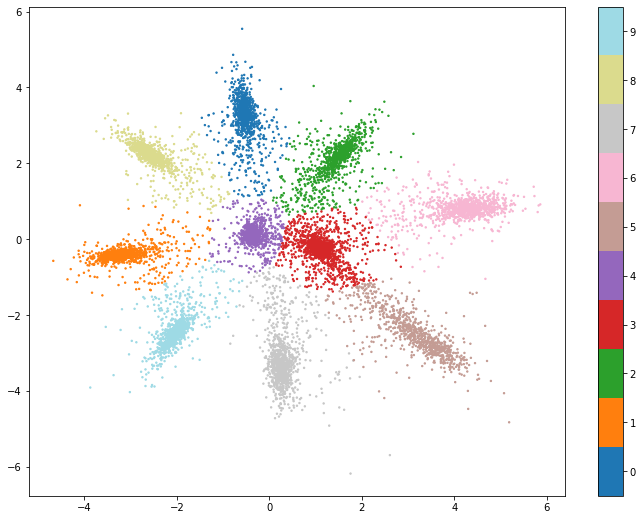

In [41]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=labels, s=2, cmap='tab20')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./output/01_prediction_c10.pdf')

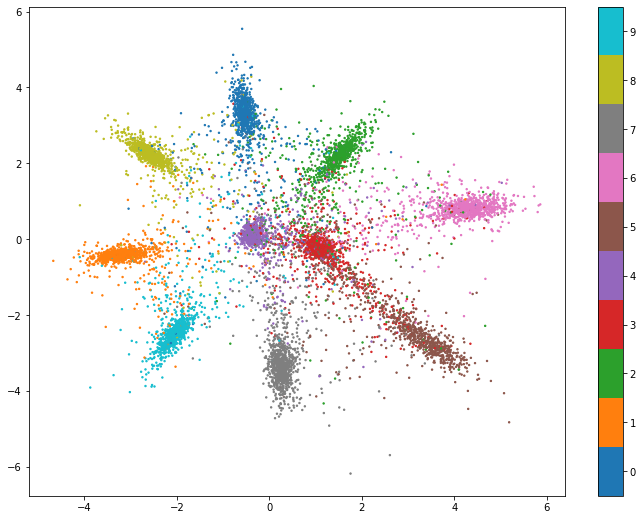

In [42]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./output/02_ground_truth_c10.pdf')

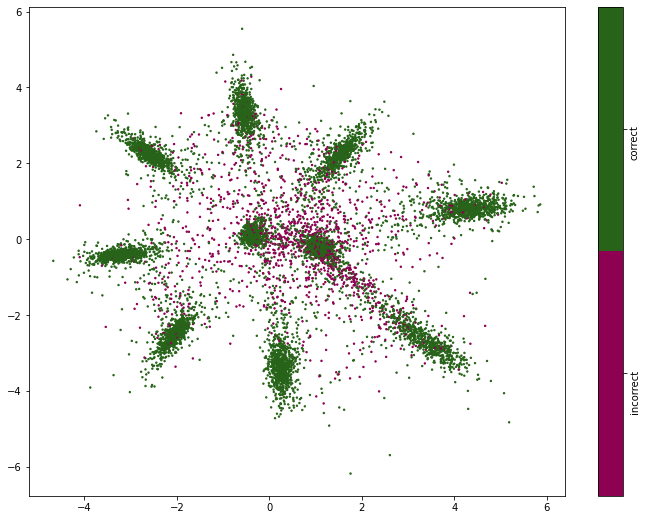

In [50]:
### Error Nodes
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=(labels==ilabels), s=2, cmap='PiYG')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['incorrect', 'correct', ])
cbar.ax.tick_params(rotation=90)

# plt.savefig('./output/03_errors_c10.pdf')

### plot on a 2D map, the decision boundary

In [44]:
ng = 1000
_a,_b,_c,_d = embeddings[:,0].min()-0.1, embeddings[:,0].max()+0.1, embeddings[:,1].min()-0.1, embeddings[:,1].max()+0.1
xg, yg = torch.linspace(_a, _b, ng), torch.linspace(_c, _d, ng)
xg, yg = torch.meshgrid(xg, yg)
xyg = torch.stack([xg.reshape(-1), yg.reshape(-1)], dim=-1)

/home/tsuman/All_Files/Program_Files/miniconda/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [45]:
BS = 1000
output = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
#         yout = classifier(xx, hard=True)
        yout = classifier(xx)
        output.append(torch.argmax(yout, dim=1).cpu())
        
output = torch.cat(output, dim=0)

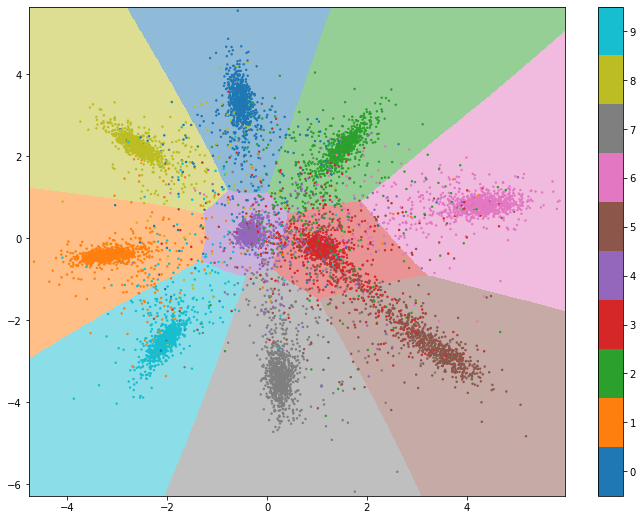

In [49]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

# plt.savefig('./output/04_DecisionBoundary_Class_c10.pdf')

In [47]:
## display different class boundary
BS = 1000
output2 = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier(xx, hard=True)
        output2.append(torch.argmax(classifier.cls_confidence, dim=1).cpu())
output2 = torch.cat(output2, dim=0)

TypeError: forward() got an unexpected keyword argument 'hard'

AttributeError: 'list' object has no attribute 'reshape'

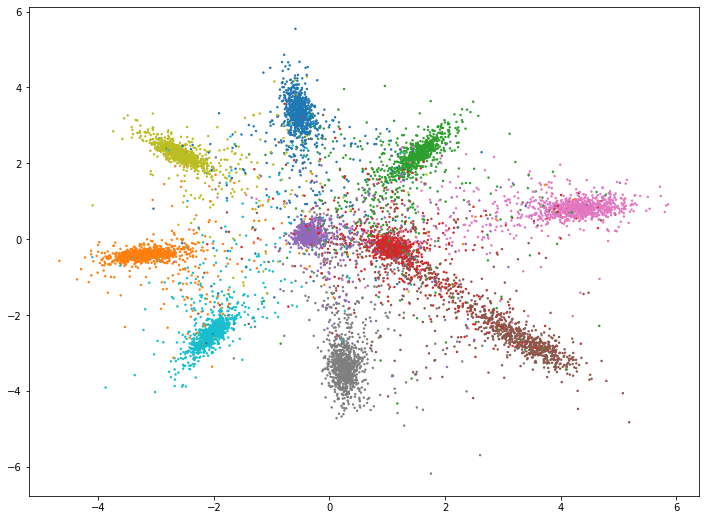

In [48]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.9, cmap='tab20',
           aspect='auto', origin='lower')

cbar = plt.colorbar(ticks=range(20), #label='classes', 
                    boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(list(range(20)))

### plot centroids as well
# plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')

plt.xlim(xg.min(), xg.max())
plt.ylim(yg.min(), yg.max()) 
# plt.savefig('./output/05_DecisionBoundary_Sets_c10.pdf')

### Hard train accuracy with count per classifier

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

In [ ]:
#### classifier with class representation
torch.argmax(classifier.cls_weight, dim=1)

### analyze per classifier accuracy

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
# set_acc/set_count

In [ ]:
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t {cnt},\t {cls}\t {acc*100:.2f}%")

## Umap -  On test set

In [27]:
import umap

In [28]:
imgs, labels = [], []
for xx, yy in tqdm(train_loader):
    imgs.append(xx)
    labels.append(yy)

imgs = torch.cat(imgs, dim=0)
labels = torch.cat(labels, dim=0)

100%|███████████████████████████████████████████████████| 391/391 [00:05<00:00, 65.60it/s]


In [29]:
embed = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.1, spread=1, metric="euclidean")
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [30]:
embedding = embed.fit_transform(imgs.numpy().reshape(-1, 32*32*3))

In [31]:
imgs_, labels_ = [], []
for xx, yy in tqdm(test_loader):
    imgs_.append(xx)
    labels_.append(yy)

imgs_ = torch.cat(imgs_, dim=0)
labels_ = torch.cat(labels_, dim=0)

100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.46it/s]


In [32]:
embedding_ = embed.transform(imgs_.numpy().reshape(-1, 32*32*3))

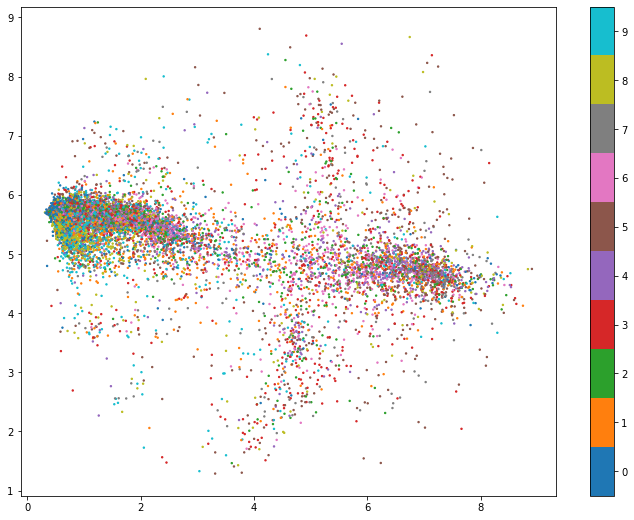

In [37]:
plt.figure(figsize=(12,9))

plt.scatter(embedding_[:,0], embedding_[:, 1], c=labels_, s=2, cmap="tab10")

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

### plot centroids as well
# plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')

# plt.xlim(xg.min(), xg.max())
# plt.ylim(yg.min(), yg.max()) 
plt.savefig('./output/UMAP_c10.pdf')

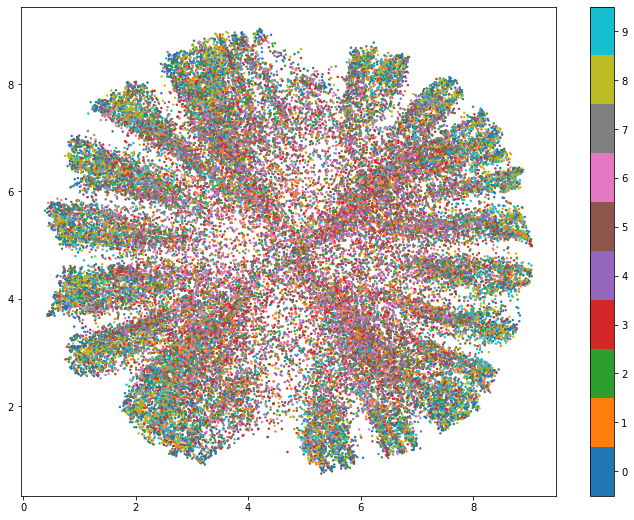

In [39]:
plt.figure(figsize=(12,9))

plt.scatter(embedding[:,0], embedding[:, 1], c=labels, s=2, cmap="tab10")

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

### plot centroids as well
# plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')

# plt.xlim(xg.min(), xg.max())
# plt.ylim(yg.min(), yg.max()) 
# plt.savefig('./output/UMAP_c10_train.pdf')